# AI 01: Model polynomiální regrese (Polynomial Regression Model)

Cílem experimentu bylo ověřit vliv podílu syntetických dat v trénovací množině na přesnost predikce doby trvání pracovní smyčky v závislosti na délce trajektorie.

Import libraries: 

In [1]:
# Instalace potřebných knihoven
#%pip instal pandas
#%pip install numpy

#%pip install scipy
#%pip install seaborn

#%pip install scikit-learn
#%pip install matplotlib
#%pip install seaborn

# actual installed version of sklearn
#%pip show scikit-learn

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Příprava trénovacích, testovacích a validačních dat

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df_train_real‘
path='../../data/06_AI/train/train_timelaps.csv'
df_train_real = pd.read_csv(path)
df_train_real.head()

,id,x,y,z,time,delay,type_delay,total_time
0,150,1315,220,1000,29,0,0,29
1,75,220,1190,500,33,0,0,33
2,239,220,940,2000,35,6,3,41
3,199,1315,220,1500,36,0,0,36
4,51,3690,220,250,50,0,0,50


In [4]:
# Soubor je načten a přiřazen do proměnné ‚df_val_real‘
path='../../data/06_AI/val/valid_timelaps.csv'
df_val_real = pd.read_csv(path)
df_val_real.head()

,id,x,y,z,time,delay,type_delay,total_time
0,13,220,2940,0,32,0,0,32
1,77,220,1690,500,33,23,2,56
2,220,2190,220,1750,35,0,0,35
3,105,252,220,750,53,0,0,53
4,45,2190,220,250,45,0,0,45


### Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

In [5]:
# SPECIFIKACE TECHNOLOGICKÉHO PROCESU ZDĚNÍ

brick_thickness = 440     # mm, tloušťka zdicího prvku (Porotherm 440 Profi)
brick_height = 250        # mm, výška zdicího prvku (Porotherm 440 Profi)
brick_width = 250         # mm, šířka zdicího prvku (Porotherm 440 Profi)

# SOUŘADNICE REFERENČNÍHO BODU (nad verifikačním stolem)

refer_x = 2_000           # mm, souřadnice X referenčního bodu
refer_y = 3_500           # mm, souřadnice Y referenčního bodu
refer_z = 1_000           # mm, souřadnice Z referenčního bodu

In [6]:
def calculation_dist(x, y, z):
    """
    Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

    Parametry:
    x, y, z (int): souřadnice cílové polohy prvku [mm]

    Návratová hodnota:
    dist (int): dráha trajektorie od referenčního bodu k cílové poloze prvku [mm]
    """
    dist = 0

    # Fáze 1: dráha od referenčního bodu k cílové stěně.
    dist = ((refer_z - (z + brick_height*2))**2 + (refer_x - brick_thickness//2)**2)**(1/2)

    # Fáze 2: dráha ve směru osy X
    if x != brick_thickness / 2:
        dist = dist + abs(x - brick_thickness//2 + brick_width * 2)

    # Fáze 3: dráha ve směru osy Y
    if y != brick_thickness / 2:
        dist = dist + abs(y - refer_y + brick_width * 2)

    return int(dist)

In [7]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
df_train_real['dist'] = df_train_real.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)
df_train_real = df_train_real[['dist', 'total_time']]
df_train_real.head()

,dist,total_time
0,3443,29
1,3590,33
2,4387,41
3,3636,36
4,5767,50


In [8]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
df_val_real['dist'] = df_val_real.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)
df_val_real = df_val_real[['dist', 'total_time']]
df_val_real.head()

,dist,total_time
0,1908,32
1,3090,56
2,4645,35
3,2329,53
4,4267,45


In [9]:
df_train_real.describe()

,dist,total_time
count,161.000000,161.000000
mean,3905.074534,41.993789
std,1216.112302,27.037358
min,1840.000000,24.000000
25%,2875.000000,32.000000
50%,3767.000000,36.000000
75%,4744.000000,42.000000
max,6609.000000,250.000000


In [10]:
df_val_real.describe()

,dist,total_time
count,108.000000,108.000000
mean,3861.675926,41.796296
std,1199.683376,28.458450
min,1908.000000,22.000000
25%,2856.500000,32.750000
50%,3911.500000,36.500000
75%,4794.000000,42.000000
max,6466.000000,296.000000


In [11]:
# Soubor je načten a přiřazen do proměnné ‚df_train_syn"
other_path = '../../data/05_Calibration/synthetic_dataset.csv'
df_train_syn = pd.read_csv(other_path, header=0)
df_train_syn[['dist', 'total_time']] = df_train_syn[['dist', 'total_time']].round().astype(int)
df_train_syn.head()

,dist,total_time
0,5484,41
1,9013,49
2,5679,41
3,9643,50
4,8990,49


In [12]:
df_train_syn.describe()

,dist,total_time
count,500000.000000,500000.000000
mean,6002.214444,45.778090
std,2314.172239,20.919695
min,2000.000000,30.000000
25%,4009.000000,37.000000
50%,5983.000000,42.000000
75%,8061.000000,47.000000
max,10000.000000,216.000000


### Funkce pro polynomiální regresi

In [13]:
def train_polynomial_model(X_train, y_train, X_val, y_val,
                           X_test, y_test, degree, scenario, train_size):

    poly = PolynomialFeatures(degree=3)

    # Transformace
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Model
    model = LinearRegression()

    # Trenovani
    model.fit(X_train_poly, y_train)

    # Validace
    y_val_pred = model.predict(X_val_poly)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Testovani (FINAL evaluation)
    y_test_pred = model.predict(X_test_poly)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results = {
        'Scenar': scenario,
        'Train_samples': train_size,
        'Degree': degree,
        'Val MSE': val_mse,
        'Val R2': val_r2,
        'Test MSE': test_mse,
        'Test R2': test_r2
    }

    return results

In [14]:
def plot_with_regression(ax, X, y, title, degree, xlim, ylim):
    # převod na 1D (kdyby byly shape (n,1))
    X = np.ravel(X)
    y = np.ravel(y)

    # linear regression (1st degree polyfit)
    coef = np.polyfit(X, y, 1)
    reg_line = np.poly1d(coef)

    # sort kvůli hezké čáře
    sort_idx = np.argsort(X)
    X_sorted = X[sort_idx]

    # fit polynomu
    coef = np.polyfit(X, y, degree)
    poly = np.poly1d(coef)

    # vytvoření hladké křivky
    X_curve = np.linspace(min(X), max(X), 200)
    y_curve = poly(X_curve)

    ax.scatter(X, y)
    ax.plot(X_sorted, reg_line(X_sorted))

    X_curve = np.linspace(min(X), max(X), 200)
    ax.plot(X_curve, y_curve)

    ax.set_xlabel("Dráha, [mm]")
    ax.set_ylabel("Čas, [sek]")
    ax.set_title(title)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.grid(True)


### Odstranění odlehlých hodnot pomocí IQR

In [15]:
def remove_outliers_iqr(df):

    Q1 = df['total_time'].quantile(0.25)
    Q3 = df['total_time'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1 * IQR
    upper = Q3 + 1 * IQR

    df_clean = df[(df['total_time'] >= lower) & (df['total_time'] <= upper)]

    return df_clean

In [16]:
df_train_real = remove_outliers_iqr(df_train_real)
df_val_real = remove_outliers_iqr(df_val_real)
df_train_syn = remove_outliers_iqr(df_train_syn)

### Trenování a vyhodnocení různých scenářů

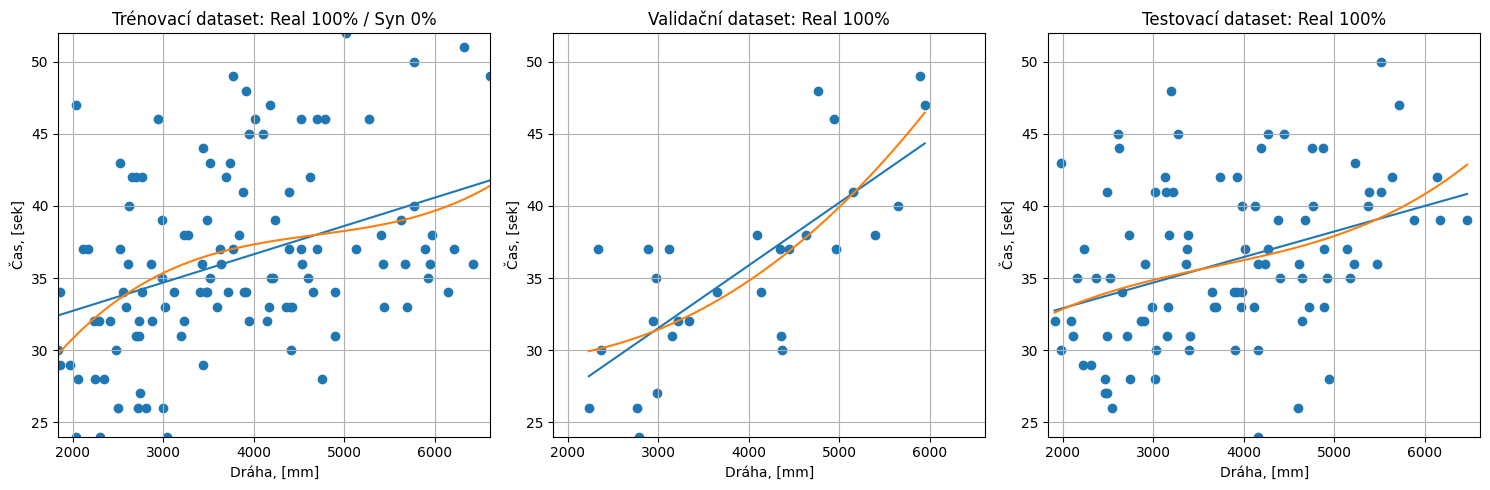

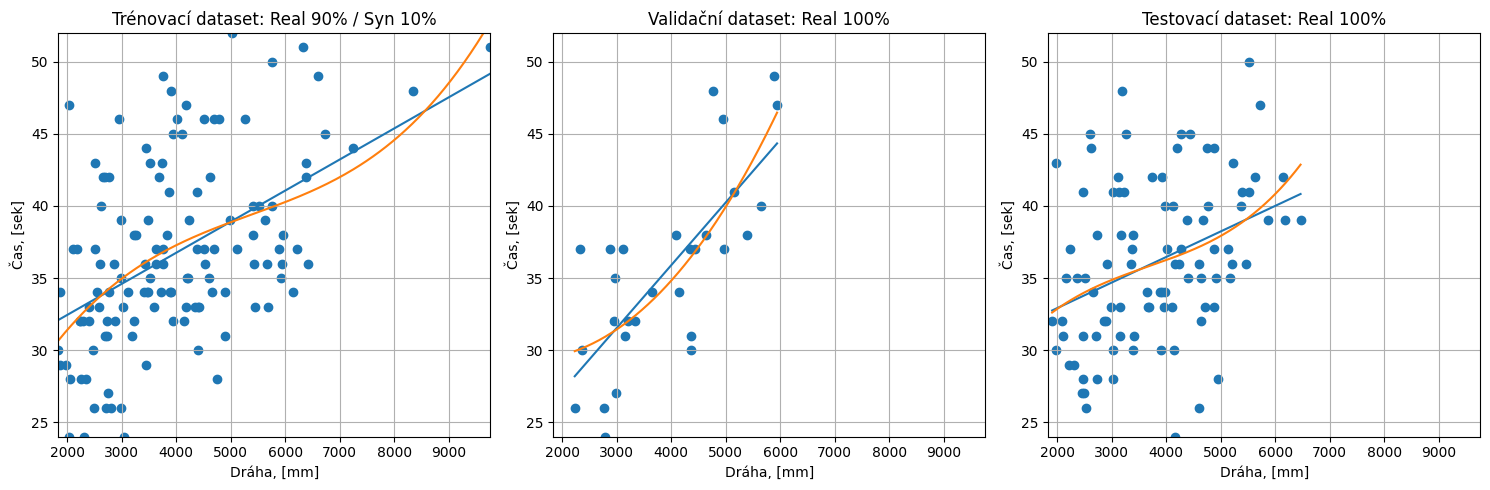

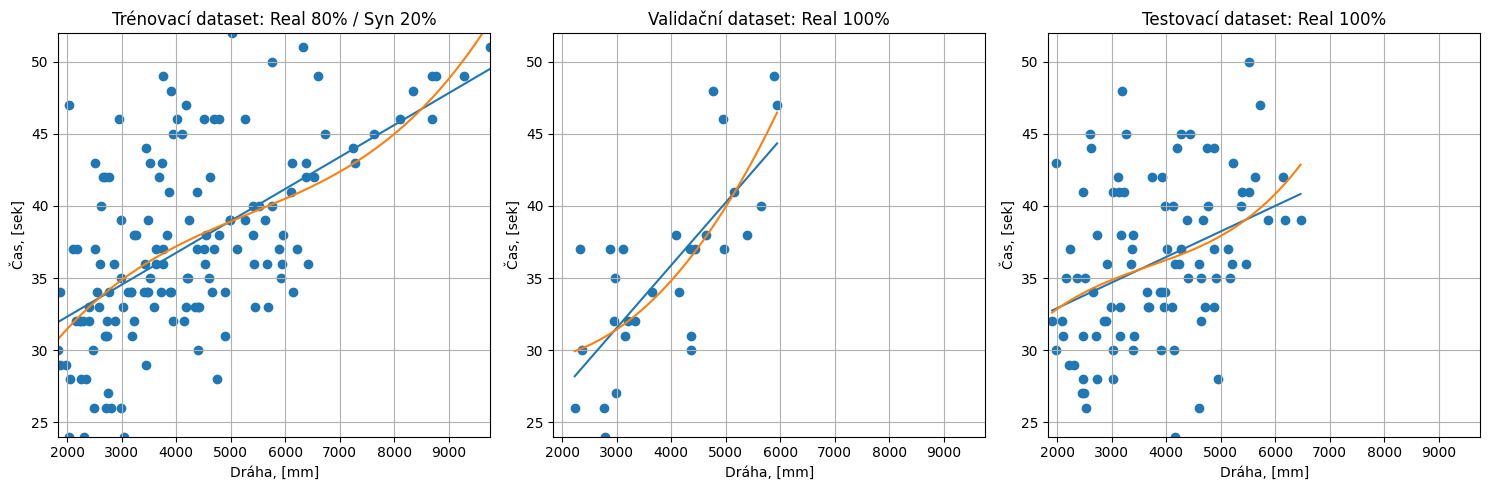

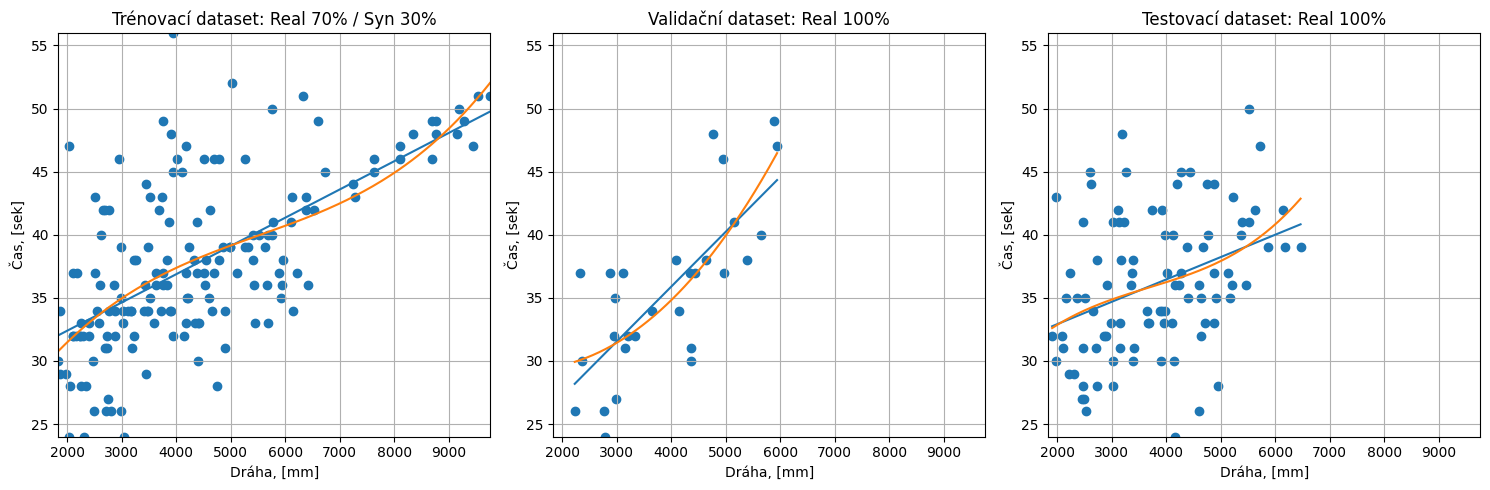

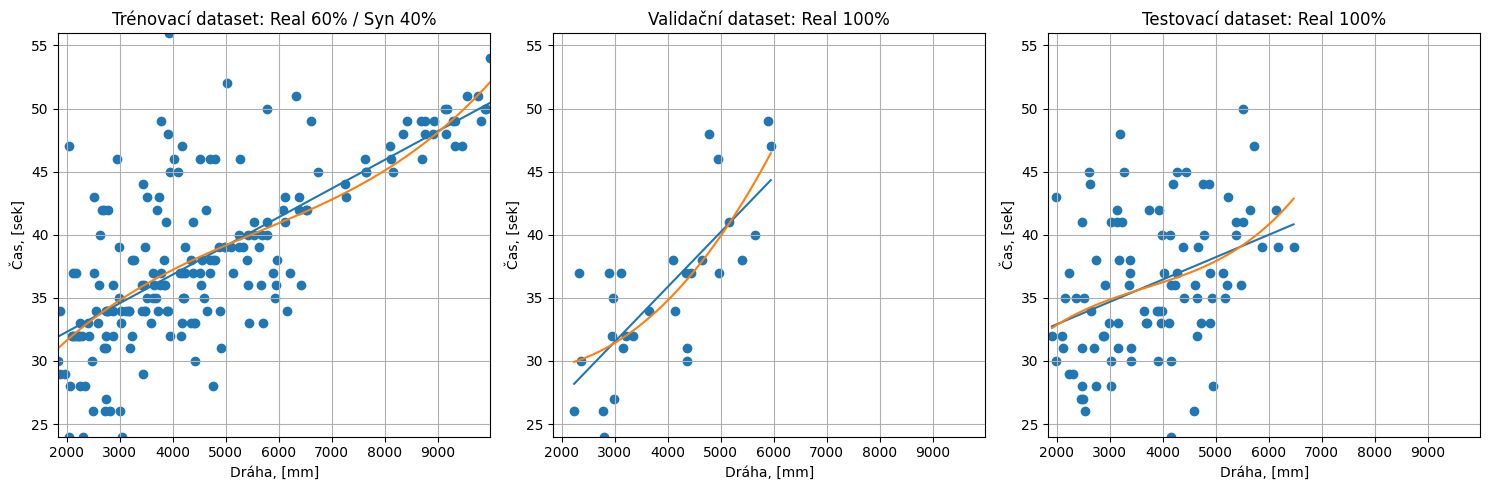

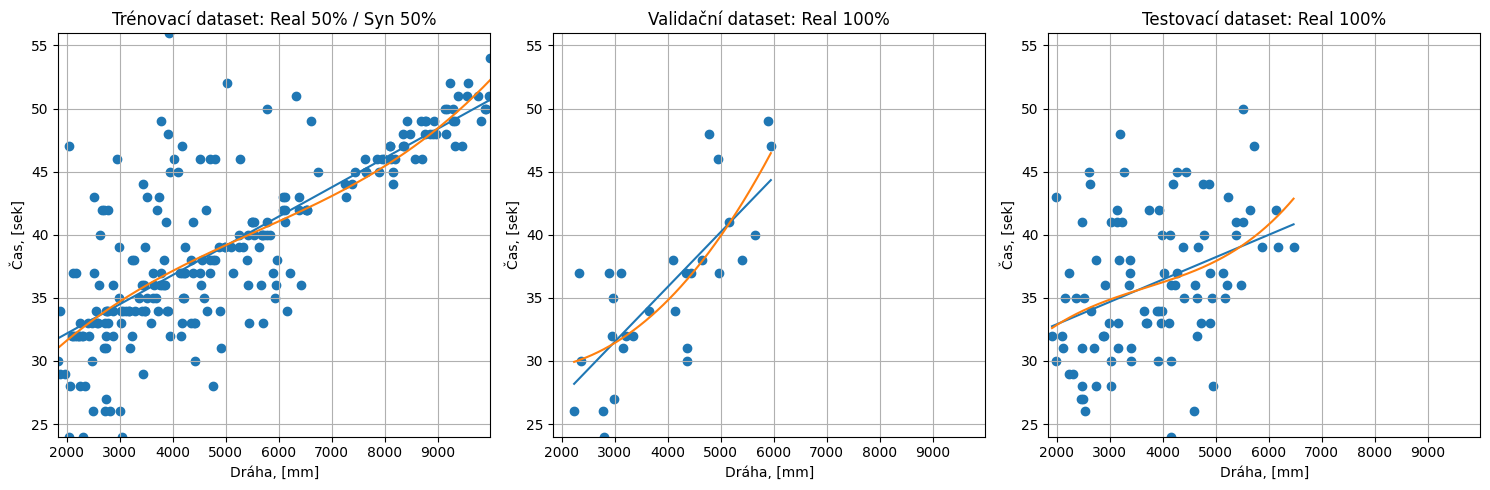

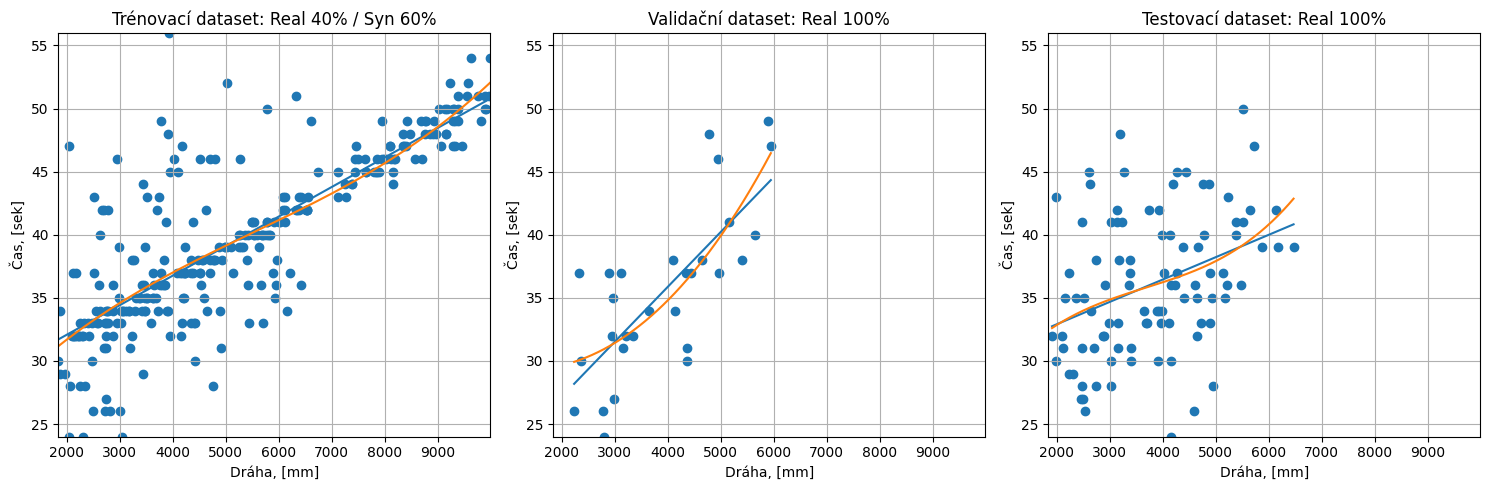

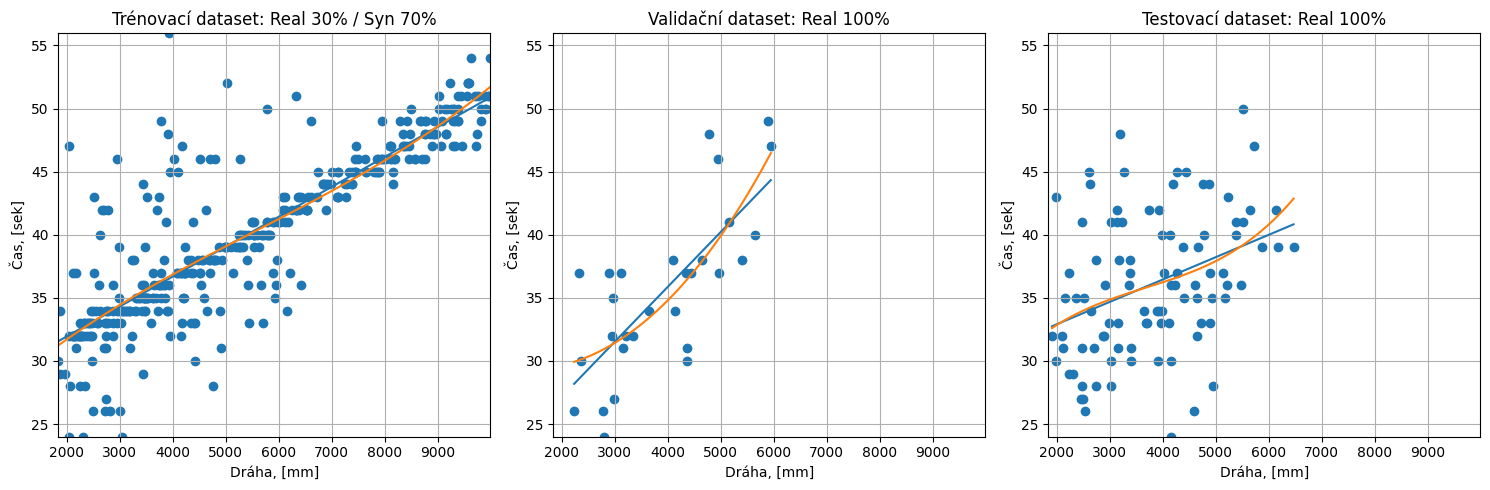

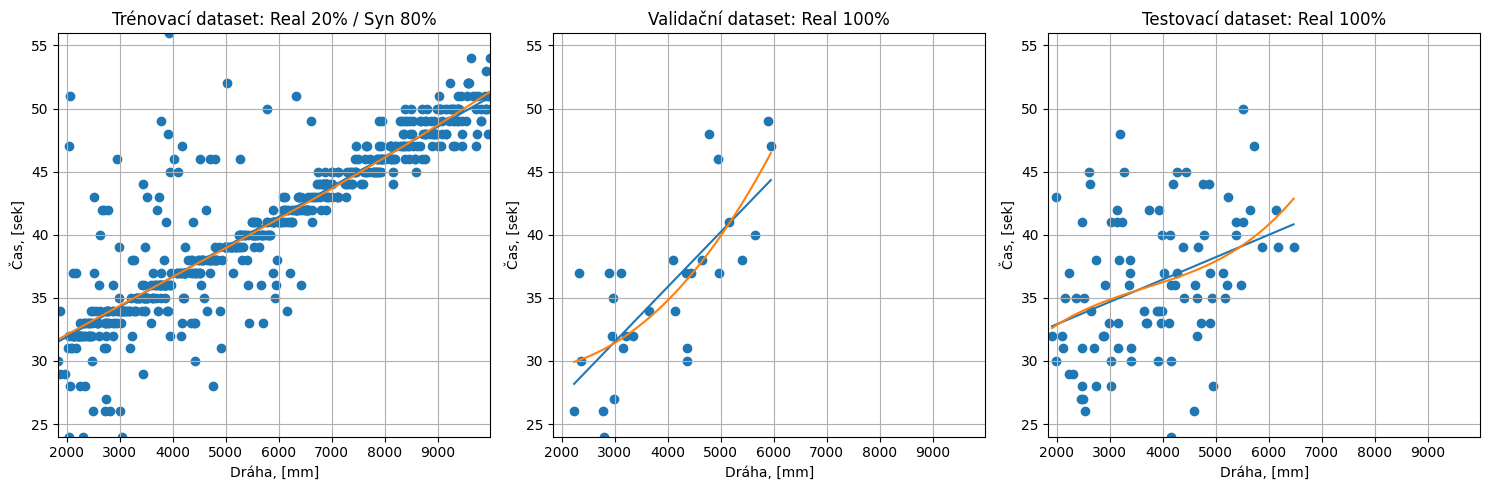

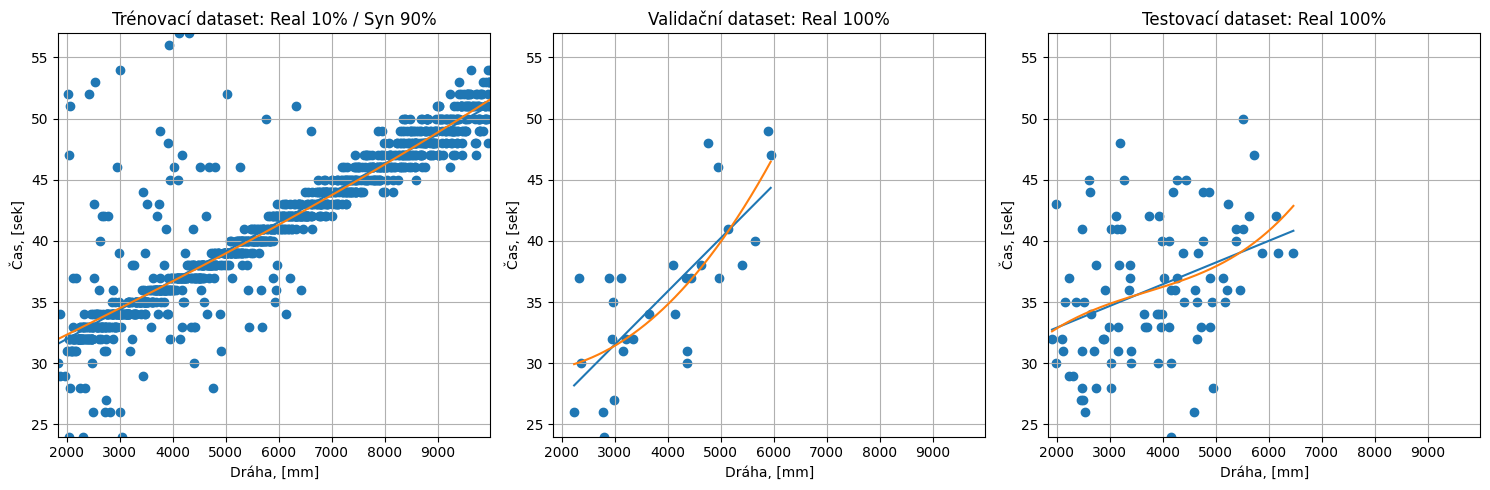

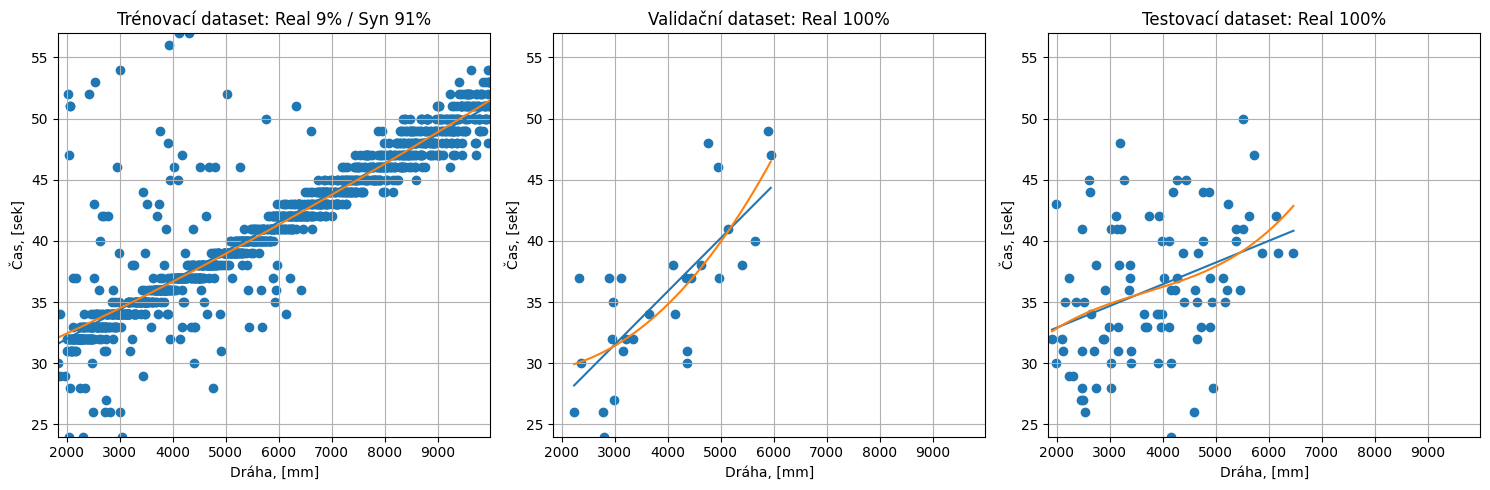

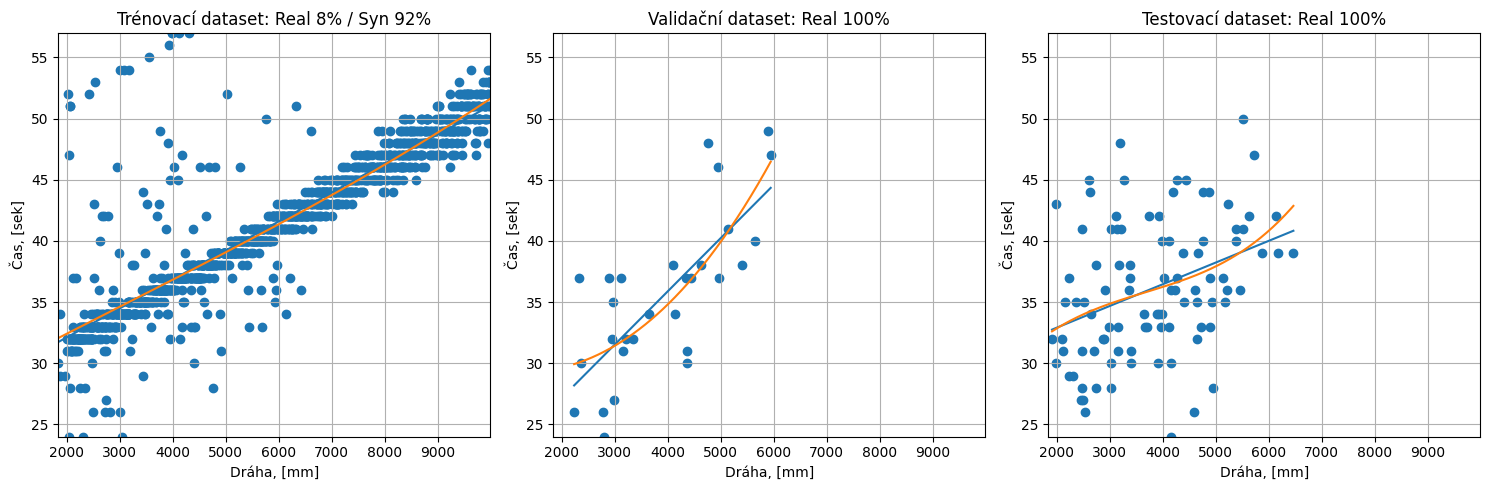

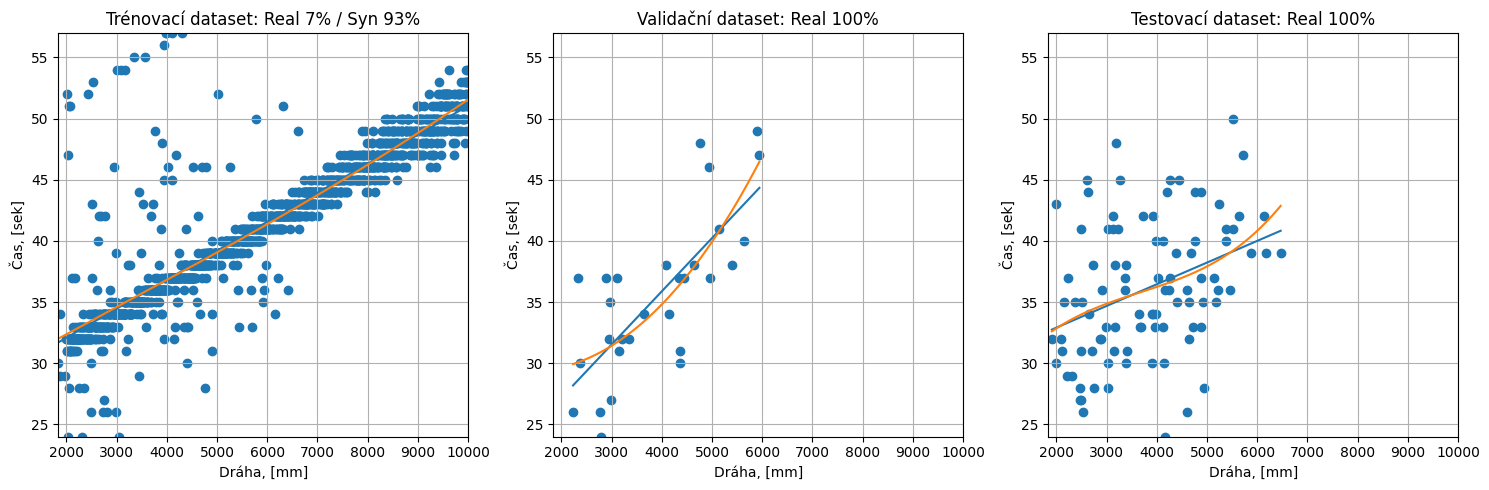

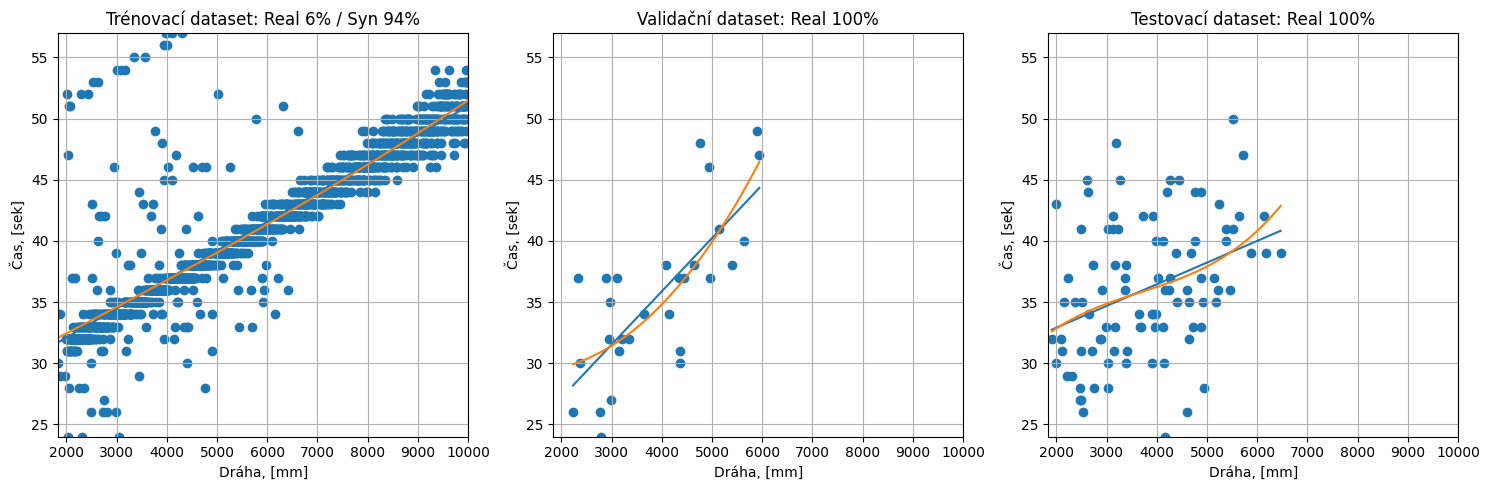

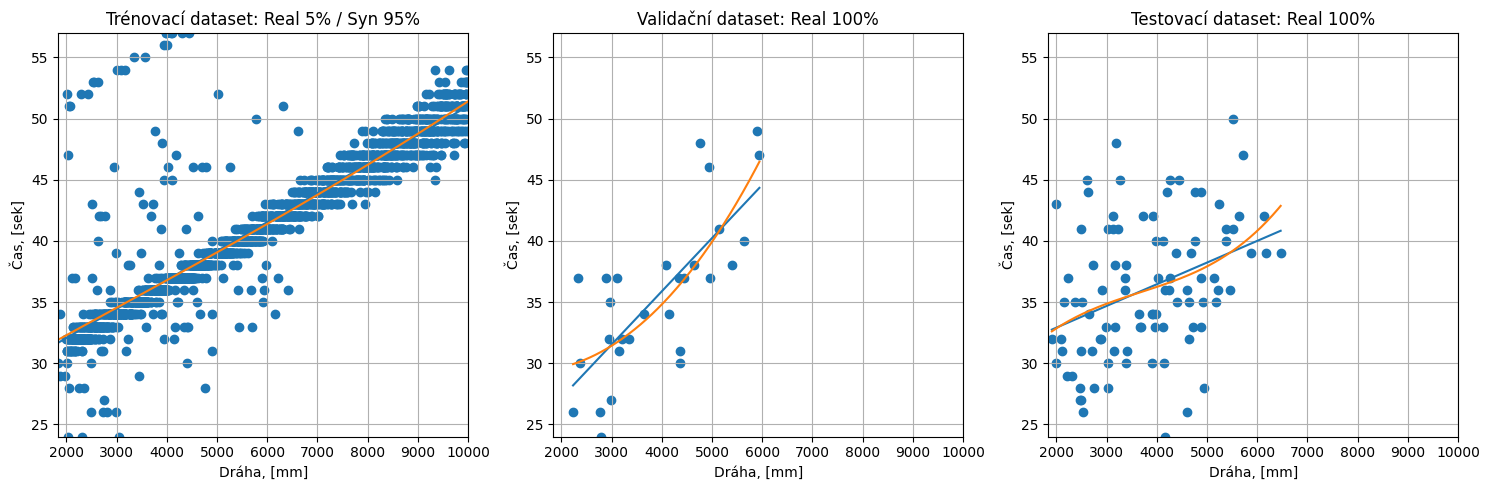

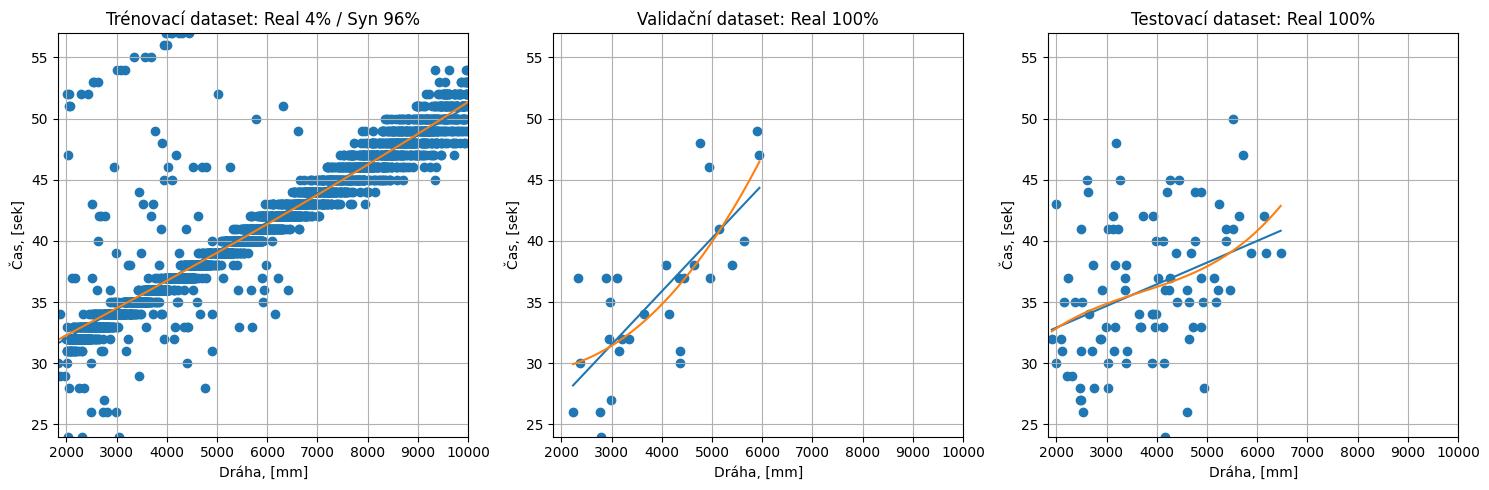

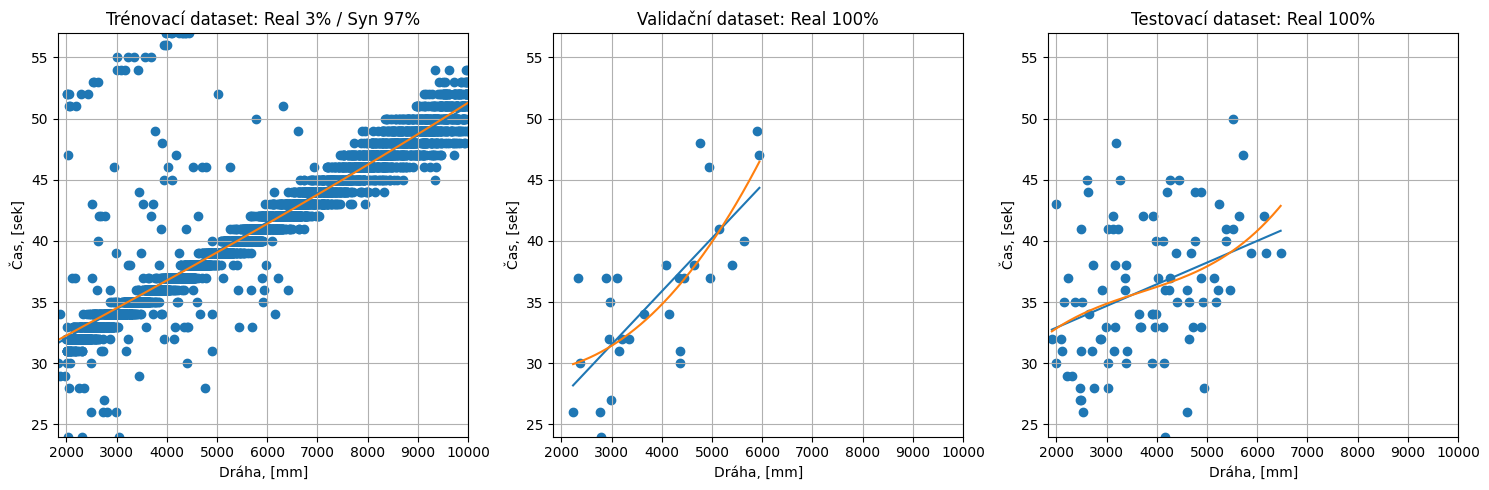

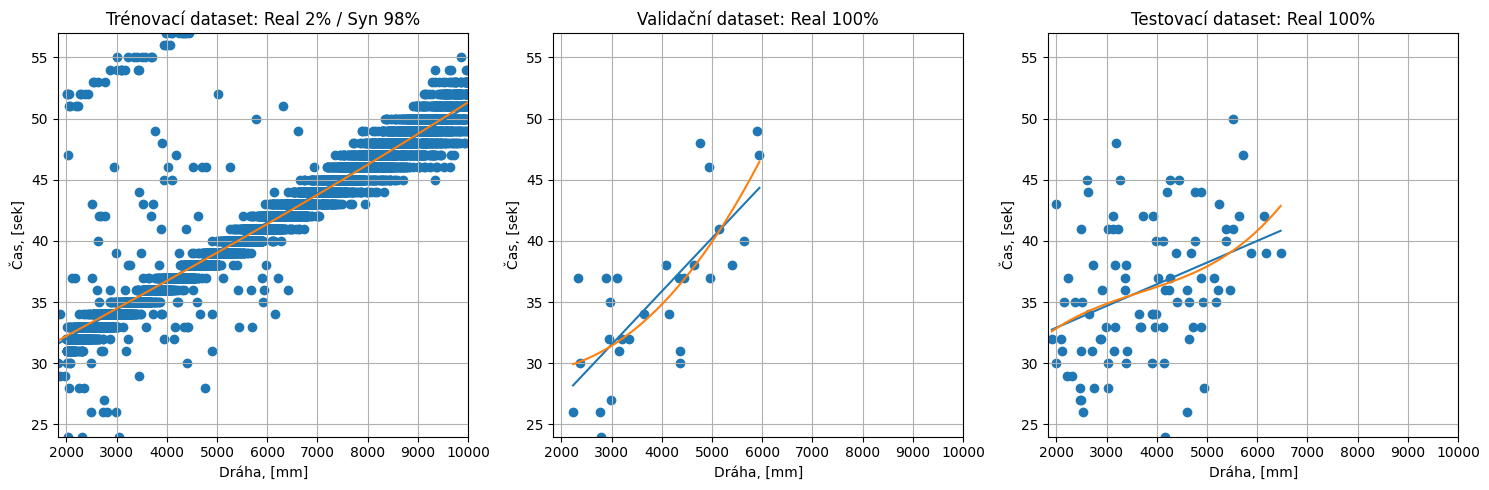

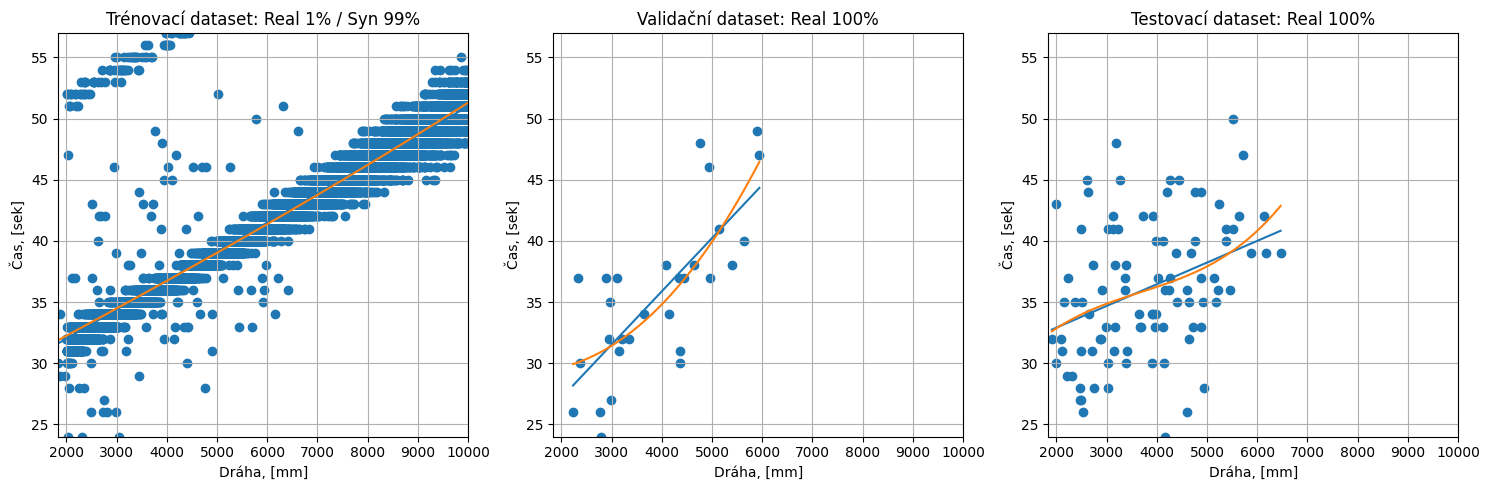

,Scenar,Train_samples,Degree,Val MSE,Val R2,Test MSE,Test R2
0,Poměr: 0.0,116,3,28.822846,0.298286,27.620732,0.107174
1,Poměr: 0.1,128,3,26.725381,0.349350,27.526903,0.110207
2,Poměr: 0.2,145,3,26.188119,0.362430,27.476380,0.111840
3,Poměr: 0.3,165,3,26.297487,0.359768,27.672674,0.105495
4,Poměr: 0.4,193,3,25.654511,0.375421,27.565630,0.108955
5,Poměr: 0.5,232,3,25.172536,0.387155,27.548786,0.109499
6,Poměr: 0.6,289,3,24.750177,0.397438,27.473780,0.111924
7,Poměr: 0.7,386,3,24.224072,0.410247,27.431108,0.113303
8,Poměr: 0.8,580,3,24.093942,0.413415,27.247001,0.119254
9,Poměr: 0.9,1160,3,24.446407,0.404834,27.195956,0.120904


In [17]:
# poměry syntetických dat pro trénování
syn_ratio = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

degree = 3

results_list = []

for ratio in syn_ratio:

    # 80 % train, 20 % val
    X_train_real, X_val, y_train_real, y_val = train_test_split(
        df_train_real[['dist']], df_train_real['total_time'], test_size=0.2, random_state=122
    )

    # počet syntetýckých vzorků
    n = len(y_train_real)
    s = int(n * ratio / (1 - ratio))
    df_syn = df_train_syn.sample(n=s, random_state=122)

    X_train_combined = pd.concat([X_train_real, df_syn[['dist']]])
    y_train_combined = pd.concat([y_train_real, df_syn['total_time']])


    # izolovaná testovací množina reálných dat
    X_real_test = df_val_real[['dist']]
    y_real_test = df_val_real['total_time']

    # === vytvoří 1 řádek, 3 sloupce ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    x_min = min(np.min(X_train_combined), np.min(X_val), np.min(X_real_test))
    x_max = max(np.max(X_train_combined), np.max(X_val), np.max(X_real_test))

    y_min = min(np.min(y_train_combined), np.min(y_val), np.min(y_real_test))
    y_max = max(np.max(y_train_combined), np.max(y_val), np.max(y_real_test))


    # ===== TRAIN =====
    plot_with_regression(
        axs[0],
        X_train_combined,
        y_train_combined,
        f"Trénovací dataset: Real {int(100 - ratio*100)}% / Syn {int(ratio*100)}%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    # ===== VALIDATION =====
    plot_with_regression(
        axs[1],
        X_val,
        y_val,
        f"Validační dataset: Real 100%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    # ===== REAL TEST =====
    plot_with_regression(
        axs[2],
        X_real_test,
        y_real_test,
        f"Testovací dataset: Real 100%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    plt.tight_layout()
    plt.show()

    res = train_polynomial_model(
        X_train_combined, y_train_combined,
        X_val, y_val,
        X_real_test, y_real_test,
        degree=degree,
        scenario=f"Poměr: {ratio}",
        train_size=(s+n)
    )
    results_list.append(res)

results = pd.DataFrame(results_list)
results

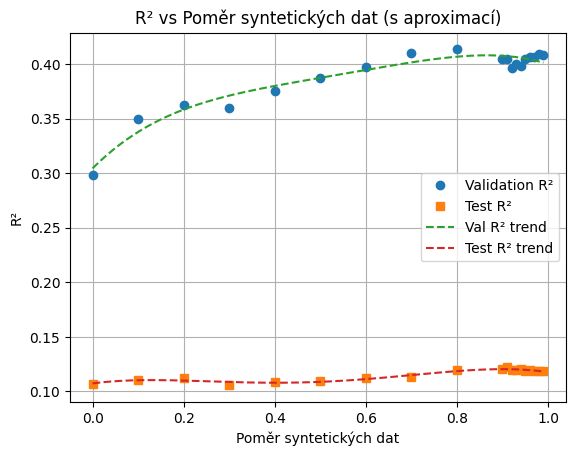

In [18]:
results['ratio'] = results['Scenar'].str.extract(r'(\d+\.\d+)').astype(float)
results['ratio'] = results['Scenar'].str.extract(r'(\d+\.\d+)').astype(float)

x = results['ratio'].values
val_r2 = results['Val R2'].values
test_r2 = results['Test R2'].values

# === aproximace (polynom) ===
deg = 4

val_coef = np.polyfit(x, val_r2, deg)
test_coef = np.polyfit(x, test_r2, deg)

val_poly = np.poly1d(val_coef)
test_poly = np.poly1d(test_coef)

x_curve = np.linspace(min(x), max(x), 200)

# === vykreslení ===
plt.figure()

plt.plot(x, val_r2, 'o', label='Validation R²')
plt.plot(x, test_r2, 's', label='Test R²')

plt.plot(x_curve, val_poly(x_curve), linestyle='--', label='Val R² trend')
plt.plot(x_curve, test_poly(x_curve), linestyle='--', label='Test R² trend')

plt.xlabel("Poměr syntetických dat")
plt.ylabel("R²")
plt.title("R² vs Poměr syntetických dat (s aproximací)")
plt.legend()
plt.grid(True)

plt.show()

V tomto experimentu je patrný pozitivní vliv navyšování podílu syntetických dat v trénovací množině na predikční schopnost modelu, a to zejména v oblasti generalizace na reálná testovací data. S rostoucím poměrem syntetických vzorků dochází k postupnému zlepšování validačních metrik, kdy hodnota Val R² roste z 0.298 při nulovém zastoupení syntetických dat až na přibližně 0.41 při poměrech kolem 0.7–0.8, což indikuje lepší zachycení závislosti mezi délkou trajektorie a dobou pracovní smyčky. Současně se mírně zlepšuje i výkonnost na testovací množině reálných dat, kde Test MSE klesá z 27.62 na minimum 27.16 a Test R² narůstá z 0.107 na maximální hodnotu 0.122 při poměru syntetických dat přibližně 0.91. Tento trend naznačuje, že syntetická data přispívají k lepšímu pokrytí prostoru vstupních proměnných a působí jako regularizační prvek, který zvyšuje stabilitu modelu. Při dalším navyšování podílu syntetických dat nad hodnotu 0.9 však dochází ke stagnaci, případně mírnému zhoršení testovacích metrik, což naznačuje dosažení bodu saturace přínosu syntetických vzorků. Celkově lze konstatovat, že optimální poměr syntetických dat se v tomto případě pohybuje okolo **0.8–0.92**, přičemž absolutní hodnoty Test R² zároveň ukazují, že délka trajektorie vysvětluje pouze omezenou část variability doby pracovní smyčky.

### Optimální poměr syntetických dat: 80 % - 92 %

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-02-05 | 1.1 | Vjačeslav Usmanov| added AI_01_Polynomial_Regression.ipynb |
| 2026-02-20 | 1.2 | Vjačeslav Usmanov| changed AI_01_Polynomial_Regression.ipynb |